### regional analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from scipy import stats
import xarray as xr
import xcdat as xc
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm as BM
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 2.0
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

#### import data

In [4]:
best = xr.open_dataset('./data/tas/Berkeley_Earth_Land_and_Ocean_LatLong1.nc')
best = best.rename(dict(latitude = 'lat', longitude = 'lon'))
best['time'] = pd.date_range(start='1850-01-01', end='2023-08-31', freq='1M')
best

<xarray.Dataset>
Dimensions:      (lon: 360, lat: 180, time: 2084, month_number: 12)
Coordinates:
  * lon          (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat          (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time         (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2023-08-31
Dimensions without coordinates: month_number
Data variables:
    land_mask    (lat, lon) float64 ...
    temperature  (time, lat, lon) float32 ...
    climatology  (month_number, lat, lon) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               16-Sep-2023 07:12:12
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   04-Sep-2023 07:26:43
    ocean_source_history:  16-Sep-2023 05:22:22
    comment:               This file contains Berkeley Earth surface temperat...

In [5]:
from functions import preprocess_temp, trend_analysis, accl_analysis

In [6]:
import regionmask

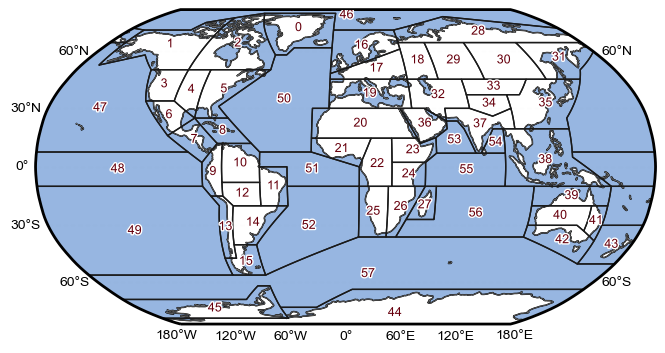

In [7]:
import matplotlib.patheffects as pe


def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE, alpha=0.9, lw=1.1)
    ax.set_global()
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax


fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.Robinson())
ax.coastlines(lw=0.7, alpha=0.7)
plot_background(ax)
text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=9,
)
regionmask.defined_regions.ar6.all.plot(text_kws=text_kws, label = "number", line_kws=dict(lw=1), add_ocean=True)
plt.savefig('./images/regions.png', dpi=300, bbox_inches='tight')

In [8]:
ar6_mask = regionmask.defined_regions.ar6.all.mask_3D(best.temperature)

In [25]:
def get_all_regional_trends(glob_temp, mask):
    slope_reg = np.empty((len(mask.region), 44, 44))
    pval_reg = np.empty((len(mask.region), 44, 44))
    duration_reg = np.empty((len(mask.region), 44, 44))
    for reg_idx in range(len(mask.region)):
        reg_mean = preprocess_temp.calc_gmst(glob_temp.where(mask.isel(region = reg_idx)))
        reg_smooth = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(reg_mean.ffill('year').bfill('year')), year = reg_mean['year'].to_numpy())).set_index('year').to_xarray().temp_smooth
        _, _, slope_reg[reg_idx, :, :], pval_reg[reg_idx, :, :], duration_reg[reg_idx, :, :] = trend_analysis.get_all_trends(reg_smooth, initial_dur=30)
        print(f'Completed {reg_idx + 1}/{len(mask.region)}', end='\r')
    return slope_reg, pval_reg, duration_reg

In [26]:
slope_reg, pval_reg, duration_reg = get_all_regional_trends(best.temperature, ar6_mask)

In [27]:
out_reg_trends = xr.Dataset(
    data_vars=dict(
        slope = (["region", "sy", "ey"], slope_reg),
        pval = (["region", "sy", "ey"], pval_reg),
        duration = (["region", "sy", "ey"], duration_reg),
    ),
    coords=dict(
        region = (["region"], ar6_mask.region.names.to_numpy()),
        sy = (["sy"], np.arange(1850, 2026, 4)),
        ey = (["ey"], np.arange(1850, 2026, 4)),
    )
)
out_reg_trends

<xarray.Dataset>
Dimensions:   (region: 58, sy: 44, ey: 44)
Coordinates:
  * region    (region) <U25 'Greenland/Iceland' ... 'Southern-Ocean'
  * sy        (sy) int64 1850 1854 1858 1862 1866 ... 2006 2010 2014 2018 2022
  * ey        (ey) int64 1850 1854 1858 1862 1866 ... 2006 2010 2014 2018 2022
Data variables:
    slope     (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan
    duration  (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan

In [28]:
out_reg_trends.to_netcdf('./data/results/trends/reg_trends.nc')

In [29]:
out_reg_trends.region

<xarray.DataArray 'region' (region: 58)>
array(['Greenland/Iceland', 'N.W.North-America', 'N.E.North-America',
       'W.North-America', 'C.North-America', 'E.North-America',
       'N.Central-America', 'S.Central-America', 'Caribbean',
       'N.W.South-America', 'N.South-America', 'N.E.South-America',
       'South-American-Monsoon', 'S.W.South-America', 'S.E.South-America',
       'S.South-America', 'N.Europe', 'West&Central-Europe', 'E.Europe',
       'Mediterranean', 'Sahara', 'Western-Africa', 'Central-Africa',
       'N.Eastern-Africa', 'S.Eastern-Africa', 'W.Southern-Africa',
       'E.Southern-Africa', 'Madagascar', 'Russian-Arctic', 'W.Siberia',
       'E.Siberia', 'Russian-Far-East', 'W.C.Asia', 'E.C.Asia',
       'Tibetan-Plateau', 'E.Asia', 'Arabian-Peninsula', 'S.Asia', 'S.E.Asia',
       'N.Australia', 'C.Australia', 'E.Australia', 'S.Australia',
       'New-Zealand', 'E.Antarctica', 'W.Antarctica', 'Arctic-Ocean',
       'N.Pacific-Ocean', 'Equatorial.Pacific-Ocean', 'S.Pacific-Ocean',
       'N.Atlantic-Ocean', 'Equatorial.Atlantic-Ocean', 'S.Atlantic-Ocean',
       'Arabian-Sea', 'Bay-of-Bengal', 'Equatorial.Indic-Ocean',
       'S.Indic-Ocean', 'Southern-Ocean'], dtype='<U25')
Coordinates:
  * region   (region) <U25 'Greenland/Iceland' ... 'Southern-Ocean'

In [57]:
slope = out_reg_trends.isel(region=0).slope
duration = out_reg_trends.isel(region=0).duration
pval = out_reg_trends.isel(region=0).pval

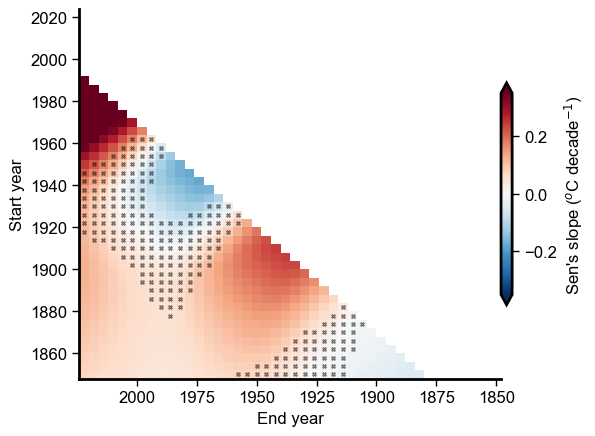

In [59]:
x, y = np.meshgrid(out_reg_trends.ey, out_reg_trends.sy)
cf =  plt.pcolormesh(x, y, slope, cmap='RdBu_r', vmin=-0.35, vmax=0.35)
# cf =  plt.pcolormesh(x, y, duration, cmap='Spectral_r')
plt.scatter(x[pval > 0.05], y[pval > 0.05], color='k', marker='x', s=7, alpha=0.5)
zm = np.ma.masked_less(pval, 0.05)
# plt.pcolor(x, y, zm, hatch='//', alpha=0.)
plt.colorbar(cf, shrink=0.6, pad=0., extend='both', label="Sen's slope ($^{o}$C decade$^{-1}$)")
plt.gca().invert_xaxis()
plt.ylabel('Start year')
plt.xlabel('End year')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.title('greenland trends')# 

In [60]:
def get_heatmap_arr(da, window=100):
    da_window = da.where(da.duration == 100)
    da_window

<xarray.Dataset>
Dimensions:   (region: 58, sy: 44, ey: 44)
Coordinates:
  * region    (region) <U25 'Greenland/Iceland' ... 'Southern-Ocean'
  * sy        (sy) int64 1850 1854 1858 1862 1866 ... 2006 2010 2014 2018 2022
  * ey        (ey) int64 1850 1854 1858 1862 1866 ... 2006 2010 2014 2018 2022
Data variables:
    slope     (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan
    pval      (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan
    duration  (region, sy, ey) float64 nan nan nan nan nan ... nan nan nan nan